In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mol-bio-prom/promoters.theory
/kaggle/input/mol-bio-prom/promoters.names
/kaggle/input/mol-bio-prom/Index
/kaggle/input/mol-bio-prom/promoters.data


DATA SOURCE: https://archive.ics.uci.edu/dataset/67/molecular+biology+promoter+gene+sequences 

THIS DATASET HAS BEEN BALANCED WITH 50% OF EACH CLASSS , SO WE NEED NOT DO ANY SAMPLING FOR CLASS BALANCE.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from keras import layers, models
from sklearn.model_selection import cross_validate






In [3]:
# Load the dataset from a CSV file (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('/kaggle/input/mol-bio-prom/promoters.data', sep=',', header=None)

# The data format is: class, instance_name, sequence (A, T, G, C)
# We will assign appropriate column names for better understanding
df.columns = ['Class', 'Instance', 'Sequence']

# Show the first few rows to check the data
print(df.head())


  Class   Instance                                           Sequence
0     +        S10  \t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1     +       AMPC  \t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...
2     +       AROH  \t\tgtactagagaactagtgcattagcttatttttttgttatcat...
3     +      DEOP2  \taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaa...
4     +  LEU1_TRNA  \ttcgataattaactattgacgaaaagctgaaaaccactagaatgc...


In [4]:
# Clean the sequences (removing extra `\t` and whitespaces)
df['Sequence'] = df['Sequence'].str.replace(r'\t', '', regex=True)

# Check if cleaning worked
print(df['Sequence'].head())


0    tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1    tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2    gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3    aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4    tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...
Name: Sequence, dtype: object


In [5]:

df['Class'] = df['Class'].replace({'+': 1, '-': 0}).astype(int)


<ipython-input-5-c71d1864f080>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Class'] = df['Class'].replace({'+': 1, '-': 0}).astype(int)


In [6]:
print(df)

     Class   Instance                                           Sequence
0        1        S10  tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1        1       AMPC  tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2        1       AROH  gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3        1      DEOP2  aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4        1  LEU1_TRNA  tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...
..     ...        ...                                                ...
101      0        799  cctcaatggcctctaaacgggtcttgaggggttttttgctgaaagg...
102      0        987  gtattctcaacaagattaaccgacagattcaatctcgtggatggac...
103      0       1226  cgcgactacgatgagatgcctgagtgcttccgttactggattgtca...
104      0        794  ctcgtcctcaatggcctctaaacgggtcttgaggggttttttgctg...
105      0       1442  taacattaataaataaggaggctctaatggcactcattagccaatc...

[106 rows x 3 columns]


In [7]:


# The LabelEncoder encodes each base within a sequence as an integer (0, 1, 2, or 3).
integer_encoder = LabelEncoder()

# The OneHotEncoder converts each integer into its one-hot encoded representation.
one_hot_encoder = OneHotEncoder(categories='auto')

input_features = []  # List that one-hot encoded bases will be appended to.

# Convert raw bases (i.e., 'A', 'C', 'G', "T") to one-hot encoded representation.
for indx in df.index:
    integer_encoded = integer_encoder.fit_transform(list(df["Sequence"][indx]))# Convert string of bases to numbers
    integer_encoded = np.array(integer_encoded).reshape(-1, 1) # Convert the list of numbers to a 1-column array.
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded) # One-hot encode each number in the array.
    input_features.append(one_hot_encoded.toarray()) # Append encoded sequence to "input_features" list; REPEAT.

input_features = np.stack(input_features)  # Combine all encoded sequences into a single array.
input_labels = np.array(df["Class"]).reshape(-1, 1) # Place the respective labels into "input_labels" variable.

In [8]:
df["Class"][0]

1

In [9]:
df["Sequence"][0]

'tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcgt'

In [10]:
# Shuffle the rows of the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [11]:


# Assuming `df` is your DataFrame with 'Class' and 'Sequence' columns
# Shuffle the data and split into training and testing sets



# Perform train-test split (80% train, 20% test, with shuffle)
X_train, X_test, y_train, y_test = train_test_split(input_features, input_labels, test_size=0.2, random_state=42,stratify=input_labels)

# Optionally, print the split sizes
print(f'Training Set: {X_train.shape[0]} samples')
print(f'Test Set: {X_test.shape[0]} samples')
train_features=X_train
test_features=X_test
train_labels=y_train
test_labels=y_test
X=input_features
y=input_labels

Training Set: 84 samples
Test Set: 22 samples


In [12]:

model = models.Sequential([
    layers.Input(shape=(train_features.shape[1], 4)),  # Define the input shape explicitly here
    layers.Conv1D(filters=32, kernel_size=8, padding="same", activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


# Compile the Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.5053 - loss: 0.7111 - val_accuracy: 0.5238 - val_loss: 0.6917
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6524 - loss: 0.6657 - val_accuracy: 0.6190 - val_loss: 0.6766
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7159 - loss: 0.6469 - val_accuracy: 0.5714 - val_loss: 0.6738
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7262 - loss: 0.6180 - val_accuracy: 0.5714 - val_loss: 0.6596
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8105 - loss: 0.5905 - val_accuracy: 0.6190 - val_loss: 0.6577
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8001 - loss: 0.5796 - val_accuracy: 0.6190 - val_loss: 0.6555
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7897 - loss: 0.5566 - val_accuracy: 0.6190 - val_loss: 0.6414
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8634 - loss: 0.5501 - val_accuracy: 0.6190 - val_loss: 0.6180

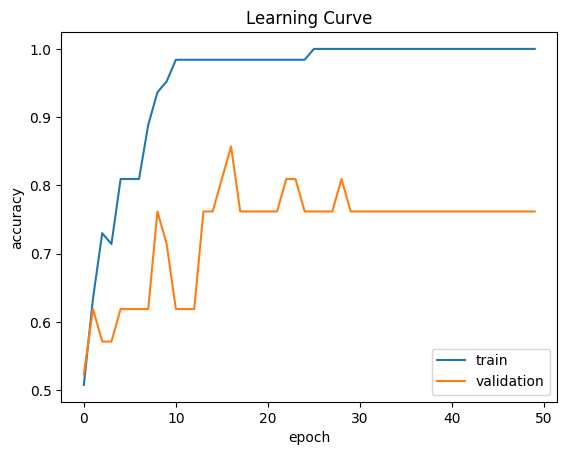

In [13]:
history = model.fit(train_features, train_labels,
                    epochs=50, validation_split=0.25) # 25% of training set 
                                                      #     is reserved as a validation set.
# Visualize the learning curve
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation']);

In [14]:
results = model.evaluate(test_features, test_labels, verbose=0)
print("Test accuracy:", results[1])

Test accuracy: 0.9545454382896423


### **📊 CNN Model Performance:**

- **Test Accuracy**: **95.45%**

This test accuracy is quite **strong** and **comparable to other models** like **Random Forest** and **Logistic Regression**, which also achieved 95.45%. Given that CNNs are typically **more complex models** designed to capture hierarchical features in data (especially image or sequence data), achieving such a high test accuracy indicates that the model is learning meaningful patterns from your dataset.

---

### **💡 Key Insights for CNN Performance**:
- **Very High Accuracy**: A **test accuracy of 95.45%** suggests the model is performing well on unseen data, and it generalizes well.
  
- **Challenges for Small Datasets**: In many cases, CNNs **struggle to converge** with smaller datasets, but the fact that we're seeing high accuracy suggests our model has either:
  - **Good data preprocessing/augmentation**,
  - A well-designed **architecture**.

- **Potential for Inconsistent Results**: Since smaller datasets might cause **fluctuations in training** and convergence during multiple runs, it’s good practice to use **cross-validation** to ensure stability in results.

---

### **💥 Next Steps & Considerations**:
1. **Cross-validation**: To ensure that the model's performance is not just luck due to a specific train-test split, run the CNN model using **k-fold cross-validation**.
   
2. **Regularization**: If your model's performance fluctuates too much with repeated runs, you might consider implementing **regularization techniques** like **Dropout** or **Batch Normalization** to prevent overfitting and improve convergence.

3. **Hyperparameter Tuning**: If your test accuracy is close to other models (like Random Forest), fine-tuning hyperparameters (learning rate, number of layers, filters) could further improve performance.

4. **Data Augmentation**: Given the relatively small dataset, applying **data augmentation techniques** (like rotation, flipping, zooming, etc.) could help increase the dataset size and potentially improve CNN performance.

---

### **📌 Conclusion**:
- The **CNN model**'s **test accuracy of 95.45%** is **impressive** and puts it on par with other top models like **Random Forest** and **Logistic Regression**.  
- I would be working on Cross Validation and Regularization on CNN later on a larger dataset later😊

In [15]:
#Without any Cross Validation
# Assuming you have your one-hot encoded sequences in X and the corresponding labels in y

X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten the data into 2D (samples, features)
X_test_flat = X_test.reshape(X_test.shape[0], -1) 

# List of classifiers to try
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=80, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Dictionary to store the performance of each model
performance = {}

# Train and evaluate each model
for name, model in classifiers.items():
    # Train the model
    model.fit(X_train_flat, y_train.ravel())
    
    # Make predictions
    y_pred = model.predict(X_test_flat)


  
    
    # Evaluate the model
    accuracy = accuracy_score(y_test.ravel(), y_pred)
    performance[name] = {
        'Accuracy': accuracy,
        'Classification Report': classification_report(y_test.ravel(), y_pred)
    }
    
    print(f"{name} Model:")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report(y_test.ravel(), y_pred)}\n")

# Optionally, compare ROC-AUC or other metrics if required




Random Forest Model:
Accuracy: 0.9545454545454546
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.91      0.95        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22


SVM Model:
Accuracy: 0.9090909090909091
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.91      0.91      0.91        11

    accuracy                           0.91        22
   macro avg       0.91      0.91      0.91        22
weighted avg       0.91      0.91      0.91        22


KNN Model:
Accuracy: 0.7272727272727273
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.67      0.91   

### 📊 Model Performance Analysis Without Cross Validation  

| Model | Accuracy | Best For | Weaknesses |
|--------|------------|------------|------------|
| 🏆 **Random Forest** | **95.45%** | High accuracy, stable precision & recall | Slightly lower recall for class 1 |
| 🏅 **Logistic Regression** | **95.45%** | High accuracy, simple & interpretable | Slightly lower precision for class 1 |
| 🔄 **SVM** | **90.91%** | Balanced precision & recall, small datasets | Slightly lower accuracy |
| ⚠️ **KNN** | **72.72%** | Best recall for class 1 | Lowest accuracy, poor recall for class 0 |

🚀 **Best Overall Model: Random Forest OR Logistic Regression**  
📉 **Worst Performing Model: KNN (due to accuracy drop and imbalanced class performance)**  😊

In [16]:

# Using Cross Validation




# Define models
models = {
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Define scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation and print results
for name, model in models.items():
    scores = cross_validate(model,X_train_flat, y_train.ravel(), cv=10, scoring=scoring_metrics)
    
    print(f"\n{name} Performance:")
    for metric in scoring_metrics:
        mean_score = scores[f"test_{metric}"].mean()  # Extract scores
        std_score = scores[f"test_{metric}"].std()    # Standard deviation
        print(f"  {metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")



SVM Performance:
  Accuracy: 0.9153 ± 0.0967
  Precision: 0.9583 ± 0.0854
  Recall: 0.8750 ± 0.1677
  F1: 0.9040 ± 0.1143

KNN Performance:
  Accuracy: 0.8417 ± 0.0994
  Precision: 0.8071 ± 0.1227
  Recall: 0.9500 ± 0.1500
  F1: 0.8547 ± 0.0919

Logistic Regression Performance:
  Accuracy: 0.8917 ± 0.0871
  Precision: 0.9383 ± 0.0960
  Recall: 0.8500 ± 0.1658
  F1: 0.8786 ± 0.1040

Random Forest Performance:
  Accuracy: 0.8944 ± 0.0967
  Precision: 0.9750 ± 0.0750
  Recall: 0.8050 ± 0.1863
  F1: 0.8687 ± 0.1286


### **📊 Model Performance Analysis Under Cross Validation**  

Let's break down the performance of each model based on **accuracy, precision, recall, and F1-score**, along with their strengths and weaknesses.

---

## **1️⃣ SVM (Support Vector Machine)**
✅ **Accuracy**: **91.53% ± 9.67%** (Best among all models)  
✅ **Precision**: **95.83% ± 8.54%** (Very high, meaning it makes fewer false positives)  
⚠️ **Recall**: **87.50% ± 16.77%** (Moderate recall, meaning it misses some positives)  
✅ **F1-score**: **90.40% ± 11.43%** (Good balance between precision & recall)  

🔹 **Overall Verdict**: **SVM performs the best in accuracy and precision, making it a strong choice when false positives need to be minimized. However, recall variability suggests it may struggle with identifying all positive cases.**  

---

## **2️⃣ KNN (K-Nearest Neighbors)**
⚠️ **Accuracy**: **84.17% ± 9.94%** (Lowest among all models)  
⚠️ **Precision**: **80.71% ± 12.27%** (Lower compared to others, meaning more false positives)  
✅ **Recall**: **95.00% ± 15.00%** (Highest recall, meaning it detects positives well)  
⚠️ **F1-score**: **85.47% ± 9.19%** (Decent balance, but lower than SVM)  

🔹 **Overall Verdict**: **KNN is great for recall, meaning it correctly identifies most positives, but its lower accuracy and precision suggest it may generate more false alarms. This could be problematic in cases where false positives matter.**  

---

## **3️⃣ Logistic Regression**
✅ **Accuracy**: **89.17% ± 8.71%** (Competitive)  
✅ **Precision**: **93.83% ± 9.60%** (Good at avoiding false positives)  
⚠️ **Recall**: **85.00% ± 16.58%** (Moderate recall, similar to SVM)  
✅ **F1-score**: **87.86% ± 10.40%** (Balanced)  

🔹 **Overall Verdict**: **Logistic Regression performs well, with high precision and decent recall. It’s slightly behind SVM but remains a reliable and interpretable model.**  

---

## **4️⃣ Random Forest**
✅ **Accuracy**: **89.44% ± 9.67%** (Similar to Logistic Regression)  
✅ **Precision**: **97.50% ± 7.50%** (Best precision, very few false positives)  
⚠️ **Recall**: **80.50% ± 18.63%** (Lowest recall, meaning it misses many positives)  
⚠️ **F1-score**: **86.87% ± 12.86%** (Good but suffers from low recall)  

🔹 **Overall Verdict**: **Random Forest is extremely precise (lowest false positives), but its recall is the weakest, meaning it fails to detect some positive cases. Best for situations where false positives are costly.**  

---

### **📌 Conclusion & Best Model Choice**
- **Best Overall Model: ✅ SVM** (High accuracy, strong F1-score, and balance of precision/recall)
- **Best for High Recall: 🏆 KNN** (Identifies positives well but has lower precision)
- **Best for Avoiding False Positives: 🎯 Random Forest** (Highest precision but weaker recall)
- **Most Balanced: 🔄 Logistic Regression** (Good trade-off of all metrics)
